In [1]:
import sys
sys.path.append('../')
from matplotlib import rcParams
rcParams['font.family'] = 'SimHei'
%matplotlib inline

In [2]:
from datafeed.dataloader import CSVDataloader
df = CSVDataloader.get_df(['000300.SH', #沪深300
                          '000905.SH', #创业板
                           '159915.SZ'
                         ])
df

,symbol,date,open,high,close,low,volume
3509,000300.SH,2010-01-04,3592.4680,3597.7480,3535.2290,3535.2290,66101080.0
3509,000905.SH,2010-01-04,4508.9300,4542.7100,4510.5270,4487.3650,51256734.0
3508,000905.SH,2010-01-05,4513.4030,4558.2100,4557.4750,4480.1880,57040745.0
3508,000300.SH,2010-01-05,3545.1860,3577.5260,3564.0380,3497.6610,85809641.0
3507,000905.SH,2010-01-06,4553.3690,4595.1020,4550.2790,4538.7190,57875979.0
...,...,...,...,...,...,...,...
2,000300.SH,2024-06-14,3514.7998,3547.1473,3541.5331,3503.5233,171516942.0
1,000300.SH,2024-06-17,3521.4365,3540.7932,3536.1986,3520.7381,137433438.0
1,000905.SH,2024-06-17,5189.2840,5223.5894,5207.1280,5184.5987,107970664.0
0,000905.SH,2024-06-18,5207.9777,5243.5867,5230.8913,5204.9707,94090903.0


In [3]:
import talib
import pybroker
import numpy as np
from numba import njit

def roc_N(bar_data, lookback):

    @njit  # Enable Numba JIT.
    def vec_roc(values):
        # Initialize the result array.
        n = len(values)
        out = np.array([np.nan for _ in range(n)])

        for i in range(lookback, n):
            out[i] = values[i]/values[i-lookback] -1
        return out

    # Calculate with close prices.
    return vec_roc(bar_data.close)

In [4]:
def pick_time(ctx):
    if not ctx.long_pos() and ctx.indicator("roc_20")[-1] > 0.08:
        ctx.buy_shares = ctx.calc_target_shares(1.0)
    if ctx.indicator("roc_20")[-1] < 0:
        ctx.sell_all_shares()
#roc_20 = pybroker.indicator('roc_20', roc_N, lookback=20)
roc_20 = pybroker.indicator('roc_20', lambda data: talib.ROC(data.close, timeperiod=20)/100)

from pybroker import Strategy,StrategyConfig
config = StrategyConfig(bars_per_year=252,exit_on_last_bar=True)

strategy = Strategy(df, '20100101','20240601',config)
strategy.add_execution(pick_time, ['159915.SZ'],indicators=[roc_20])
result = strategy.backtest()
result.orders

Backtesting: 2010-01-01 00:00:00 to 2024-06-01 00:00:00

Computing indicators...


100% (1 of 1) |##########################| Elapsed Time: 0:00:00 Time:  0:00:00



Test split: 2011-12-09 00:00:00 to 2024-05-28 00:00:00


100% (3025 of 3025) |####################| Elapsed Time: 0:00:00 Time:  0:00:000:00



Finished backtest: 0:00:05


,type,symbol,date,shares,limit_price,fill_price,fees
id,,,,,,,
1,buy,159915.SZ,2012-02-21,136986,NaN,0.73,0.0
2,sell,159915.SZ,2012-03-22,136986,NaN,0.75,0.0
3,buy,159915.SZ,2012-12-26,146771,NaN,0.70,0.0
4,sell,159915.SZ,2013-04-01,146771,NaN,0.86,0.0
5,buy,159915.SZ,2013-05-06,132866,NaN,0.95,0.0
...,...,...,...,...,...,...,...
60,sell,159915.SZ,2022-11-14,371361,NaN,2.32,0.0
61,buy,159915.SZ,2023-01-18,351665,NaN,2.47,0.0
62,sell,159915.SZ,2023-02-20,351665,NaN,2.38,0.0


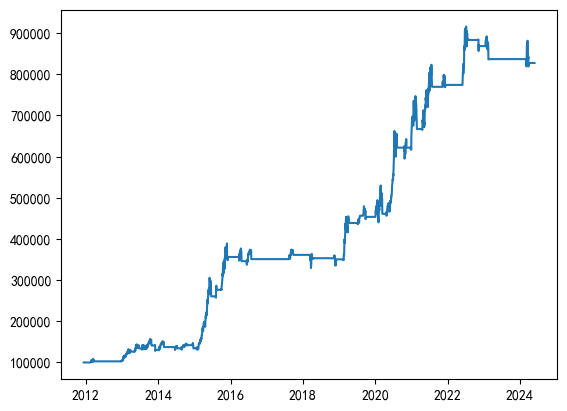

In [5]:
import matplotlib.pyplot as plt

chart = plt.subplot2grid((3, 2), (0, 0), rowspan=3, colspan=2)
chart.plot(result.portfolio.index, result.portfolio['market_value'])

In [6]:
result.metrics_df

,name,value
0,trade_count,3.200000e+01
1,initial_market_value,1.000000e+05
2,end_market_value,8.275758e+05
3,total_pnl,7.275758e+05
4,unrealized_pnl,0.000000e+00
5,total_return_pct,7.275758e+02
6,annual_return_pct,1.925009e+01
7,total_profit,8.283106e+05
8,total_loss,-1.007348e+05
9,total_fees,0.000000e+00
